## Lesson 1

Before working on dogs vs cats classification, lets first use the original vgg16 and make some predictions on imagenet classes, however using the data sitting in dogscats dataset.

Also, rather than using vgg16 directly, lets define that architecture ourselves. Also, we will use tf as backend.

To do that, lets create some functions for conv and fc blocks used in vgg16.

### Loading some modules

In [40]:
import numpy as np
%pylab inline
import json
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.utils import get_file
from keras.preprocessing import image
from utils import plots
from keras import backend as K
K.set_image_dim_ordering('tf')

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Some vgg16 specific parameters

In [2]:
image_size = 224

### Some functions

In [3]:
def ConvBlock(model, nlayers, nchannels):
    for i in np.arange(nlayers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(filters=nchannels, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

In [4]:
def FCBlock(model, nlayers, nnodes):
    for i in np.arange(nlayers):
        model.add(Dense(units=nnodes, activation="relu"))
        model.add(Dropout(rate = 0.5))

### Lets now define the vgg16 model

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [5]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((1,1,3))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:,:, ::-1]    # reverse axis bgr->rgb

In [10]:
def vgg16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(image_size, image_size, 3)))
    
    # Conv blocks
    ConvBlock(model, nlayers=2, nchannels=64)
    ConvBlock(model, nlayers=2, nchannels=128)
    ConvBlock(model, nlayers=3, nchannels=256)
    ConvBlock(model, nlayers=3, nchannels=512)
    ConvBlock(model, nlayers=3, nchannels=512)
    
    # FC blocks
    model.add(Flatten())
    FCBlock(model, nlayers=2, nnodes=4096)
    model.add(Dense(units=1000, activation="softmax"))
    
    return(model)

Having defined the architecture, lets create the model.

In [11]:
model = vgg16()

This model is currently empty in a sense that there are no weights (or model parameters) assinged. Lets load the weights into this empty model and make it complete!

### Loading weights

In [12]:
# The h5 file in fast.ai does not work as that is setup for theano. We are working using tf as backend, so we download from a different source.
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
fpath = get_file(fname='vgg16tf.h5', origin=WEIGHTS_PATH, cache_subdir='pre_trained_cnn_models')
model.load_weights(fpath)

We should also load the json file to get class names.

In [41]:
json_path = 'http://files.fast.ai/models/imagenet_class_index.json'
jpath = get_file('imagenet_class_index.json', json_path, cache_subdir='pre_trained_cnn_models')
with open(jpath) as f:
    class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

Having the model loaded with weights, we can now make some predictions. To do that, lets grab a batch of images and make predictions on them.

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data.

Our data is located in data/dogscats/sample.

### Loading data

In [42]:
path = "data/dogscats/sample/"
batch_size = 4

In [43]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [44]:
train_batches = get_batches(dirname="train", batch_size=batch_size)

Found 16 images belonging to 2 classes.


In [45]:
valid_batches = get_batches(dirname="valid", batch_size=batch_size)

Found 8 images belonging to 2 classes.


We have total 4 batches with each batch containing 4 images in the train directory. Lets predict the classes for these 16 images, batch by batch.

### Predictions

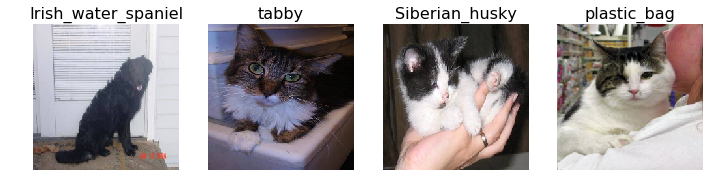

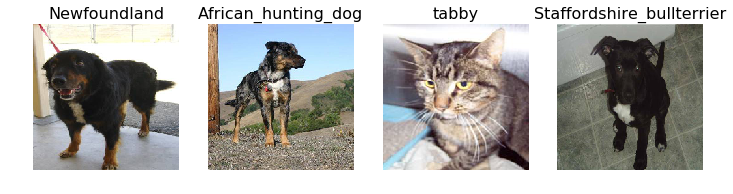

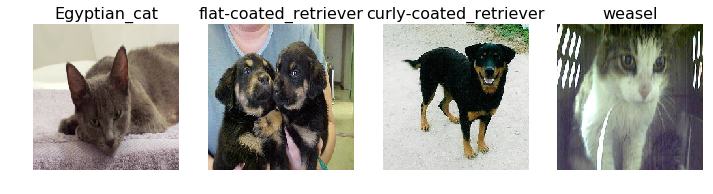

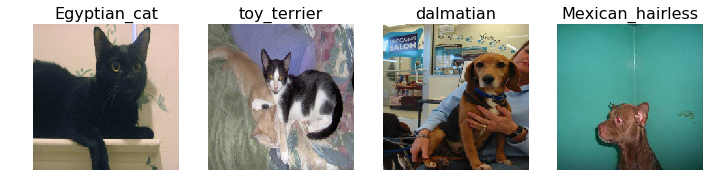

In [67]:
for b in np.arange(int(train_batches.n/batch_size)):
    imgs, labels = train_batches.next()
    prob_pred = model.predict(imgs)
    labs = [classes[i] for i in np.argmax(prob_pred, axis=1)]
    plots(imgs, titles = labs)